In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create the main project directory
project_path = "/content/drive/MyDrive/capstone-skin-prog"
os.makedirs(project_path, exist_ok=True)

# Create subfolders for data, models, etc.
folders = ["data/raw/images", "data/raw/masks", "data/preprocessed",
           "models", "logs", "src", "notebooks"]
for f in folders:
    os.makedirs(os.path.join(project_path, f), exist_ok=True)

print("Project structure created at:", project_path)

# Install necessary libraries
print("Installing required libraries...")
!pip install torch torchvision --quiet
!pip install tqdm pandas numpy opencv-python scikit-image albumentations matplotlib pillow scikit-learn --quiet
!pip install segmentation-models-pytorch --quiet
print("✅ Libraries installed!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project structure created at: /content/drive/MyDrive/capstone-skin-prog
Installing required libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.8 MB/s eta 0:00:00
✅ Libraries installed!


In [ ]:
import os

# Paths
zip_path = "/content/drive/MyDrive/capstone-skin-prog/data/raw/ISIC_2024_Training_Input.zip"
local_extract = "/content/ISIC_2024_Training_Input"

# Extract locally (much faster than Drive)
!unzip -q "$zip_path" -d "$local_extract"

print("✅ Extracted locally to:", local_extract)


✅ Extracted locally to: /content/ISIC_2024_Training_Input


In [ ]:
import os, pandas as pd
from glob import glob

# Paths
base_path = "/content/drive/MyDrive/capstone-skin-prog"
img_dir   = os.path.join(base_path, "data/raw/images/ISIC_2024_Training_Input")
gt_csv    = os.path.join(base_path, "data/raw/ISIC_2024_Training_GroundTruth.csv")
supp_csv  = os.path.join(base_path, "data/raw/ISIC_2024_Training_Supplement.csv")
out_csv   = os.path.join(base_path, "data/manifest.csv")

# Load metadata
gt   = pd.read_csv(gt_csv)
supp = pd.read_csv(supp_csv, engine="python", on_bad_lines="skip")
meta = gt.merge(supp, on="isic_id", how="left")

# Collect image paths
image_files = glob(os.path.join(img_dir, "*.jpg")) + glob(os.path.join(img_dir, "*.png"))
print("Found", len(image_files), "images in", img_dir)

df_imgs = pd.DataFrame({"image_path": image_files})
df_imgs["isic_id"] = df_imgs["image_path"].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

# Merge with metadata
df = df_imgs.merge(meta, on="isic_id", how="left")

# Save manifest
df.to_csv(out_csv, index=False)
print("✅ Manifest saved at:", out_csv)
print("Total rows:", len(df))
print(df.head())


Found 79959 images in /content/drive/MyDrive/capstone-skin-prog/data/raw/images/ISIC_2024_Training_Input
✅ Manifest saved at: /content/drive/MyDrive/capstone-skin-prog/data/manifest.csv
Total rows: 79959
                                          image_path       isic_id  malignant  \
0  /content/drive/MyDrive/capstone-skin-prog/data...  ISIC_0586598          0   
1  /content/drive/MyDrive/capstone-skin-prog/data...  ISIC_0586593          0   
2  /content/drive/MyDrive/capstone-skin-prog/data...  ISIC_0586588          0   
3  /content/drive/MyDrive/capstone-skin-prog/data...  ISIC_0586583          0   
4  /content/drive/MyDrive/capstone-skin-prog/data...  ISIC_0586613          0   

                                         attribution copyright_license  \
0             Memorial Sloan Kettering Cancer Center             CC-BY   
1             Memorial Sloan Kettering Cancer Center             CC-BY   
2  Department of Dermatology, Hospital Clínic de ...          CC-BY-NC   
3  Department

In [ ]:
from sklearn.model_selection import train_test_split
import os

base_path = "/content/drive/MyDrive/capstone-skin-prog"
train_csv = os.path.join(base_path, "data/train_manifest.csv")
val_csv   = os.path.join(base_path, "data/val_manifest.csv")
test_csv  = os.path.join(base_path, "data/test_manifest.csv")

# Load manifest
df = pd.read_csv(os.path.join(base_path, "data/manifest.csv"))

# Stratified split by malignant
train, temp = train_test_split(
    df, test_size=0.30, random_state=42, stratify=df["malignant"]
)
val, test = train_test_split(
    temp, test_size=0.50, random_state=42, stratify=temp["malignant"]
)

# Save
train.to_csv(train_csv, index=False)
val.to_csv(val_csv, index=False)
test.to_csv(test_csv, index=False)

print("✅ Splits saved!")
print("Train:", len(train), "Val:", len(val), "Test:", len(test))
print("\nMalignant distribution:")
print("Train:", train['malignant'].value_counts(normalize=True))
print("Val:", val['malignant'].value_counts(normalize=True))
print("Test:", test['malignant'].value_counts(normalize=True))


/tmp/ipython-input-3799193952.py:10: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(base_path, "data/manifest.csv"))


✅ Splits saved!
Train: 55971 Val: 11994 Test: 11994

Malignant distribution:
Train: malignant
0    0.998946
1    0.001054
Name: proportion, dtype: float64
Val: malignant
0    0.998916
1    0.001084
Name: proportion, dtype: float64
Test: malignant
0    0.998999
1    0.001001
Name: proportion, dtype: float64


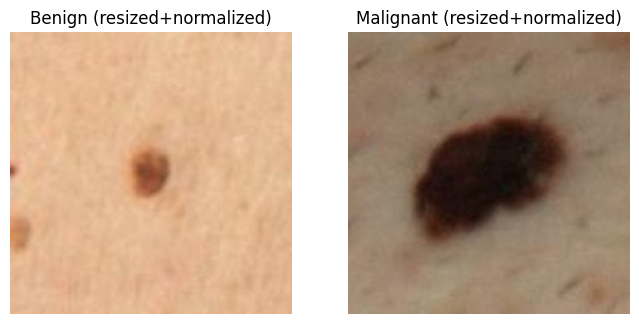

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Example: pick one malignant + one benign
sample_benign = train[train["malignant"]==0].iloc[0]["image_path"]
sample_malignant = train[train["malignant"]==1].iloc[0]["image_path"]

def preprocess_image(path, size=224):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size, size))
    img = img / 255.0  # normalize to [0,1]
    return img

benign_img = preprocess_image(sample_benign)
malignant_img = preprocess_image(sample_malignant)

# Show before/after
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].imshow(benign_img)
axs[0].set_title("Benign (resized+normalized)")
axs[0].axis("off")

axs[1].imshow(malignant_img)
axs[1].set_title("Malignant (resized+normalized)")
axs[1].axis("off")

plt.show()


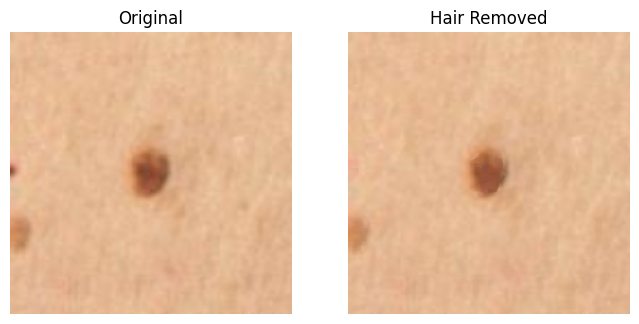

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def hair_removal(img):
    gray = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(1,(17,17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _,thresh2 = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    dst = cv2.inpaint((img*255).astype(np.uint8), thresh2, 1, cv2.INPAINT_TELEA)
    return dst/255.0

# Apply on the benign example
hairless_img = hair_removal(benign_img)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(benign_img); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(hairless_img); plt.title("Hair Removed"); plt.axis("off")
plt.show()


In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
base_path = "/content/drive/MyDrive/capstone-skin-prog/data"

train_csv = os.path.join(base_path, "train_manifest.csv")
val_csv   = os.path.join(base_path, "val_manifest.csv")
test_csv  = os.path.join(base_path, "test_manifest.csv")


In [ ]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((128,128)),   # smaller, faster
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

class SkinDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        label = self.data.iloc[idx]["malignant"]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)


In [ ]:
# Sample smaller dataset for quick training
train_df = pd.read_csv(train_csv).sample(n=5000, random_state=42)
val_df   = pd.read_csv(val_csv).sample(n=1000, random_state=42)
test_df  = pd.read_csv(test_csv).sample(n=1000, random_state=42)

train_df.to_csv("/content/small_train.csv", index=False)
val_df.to_csv("/content/small_val.csv", index=False)
test_df.to_csv("/content/small_test.csv", index=False)

# Load datasets
train_ds = SkinDataset("/content/small_train.csv", transform=transform)
val_ds   = SkinDataset("/content/small_val.csv", transform=transform)
test_ds  = SkinDataset("/content/small_test.csv", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

print("✅ Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))


✅ Train: 5000 Val: 1000 Test: 1000


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: benign, malignant
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("✅ Model ready on", device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:02<00:00, 19.6MB/s]


✅ Model ready on cpu


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=3):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = 100.*correct/total

        # Validation
        model.eval()
        v_loss, v_correct, v_total = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                v_loss += loss.item()
                _, preds = outputs.max(1)
                v_correct += preds.eq(labels).sum().item()
                v_total += labels.size(0)

        val_loss = v_loss / len(val_loader)
        val_acc = 100.*v_correct/v_total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    return history

In [ ]:
# Run for 3 epochs (fast demo run)
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=3)

Epoch 1/3 | Train Loss: 0.1445, Acc: 94.26% | Val Loss: 0.0254, Acc: 99.70%
Epoch 2/3 | Train Loss: 0.0086, Acc: 99.92% | Val Loss: 0.0195, Acc: 99.70%
Epoch 3/3 | Train Loss: 0.0030, Acc: 100.00% | Val Loss: 0.0176, Acc: 99.70%


              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       998
   Malignant       0.00      0.00      0.00         2

    accuracy                           1.00      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       1.00      1.00      1.00      1000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


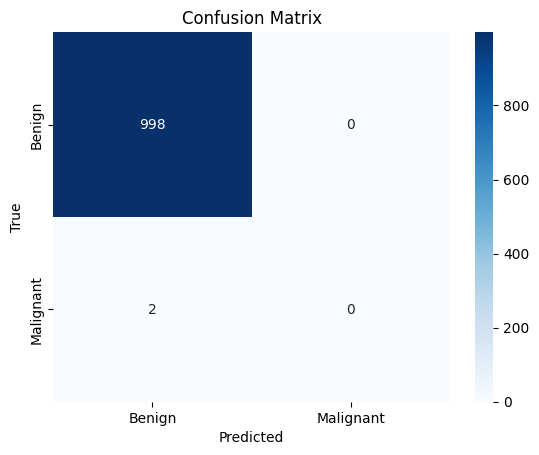

In [ ]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=["Benign","Malignant"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign","Malignant"],
            yticklabels=["Benign","Malignant"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Make sure device is defined
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now U-Net works
unet = UNet(in_channels=3, out_channels=1).to(device)
print("✅ U-Net ready on", device)

In [ ]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.bottleneck = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.out(d1))

# Instantiate model
unet = UNet(in_channels=3, out_channels=1).to(device)
print("✅ U-Net ready on", device)

In [ ]:
# Pix2Pix Generator
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super(UNetGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1), nn.LeakyReLU(0.2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(features, out_channels, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# Pix2Pix Discriminator
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super(PatchDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features, features*2, 4, 2, 1),
            nn.InstanceNorm2d(features*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features*2, 1, 4, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)


In [ ]:
class SimpleDiffusion(nn.Module):
    def __init__(self, img_channels=3):
        super(SimpleDiffusion, self).__init__()
        self.denoise = nn.Sequential(
            nn.Conv2d(img_channels, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, img_channels, 3, padding=1)
        )
    def forward(self, x):
        return self.denoise(x)

def add_noise(img, noise_factor=0.2):
    noisy = img + noise_factor * torch.randn_like(img)
    return torch.clamp(noisy, -1, 1)


In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

# Load one sample image (benign example)
img_path = sample_benign  # you already defined earlier
img = Image.open(img_path).convert("RGB")

# Transform to tensor
transform_demo = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])
img_tensor = transform_demo(img).unsqueeze(0).to(device)

# Forward pass through U-Net (random weights → fake mask)
unet.eval()
with torch.no_grad():
    mask_pred = unet(img_tensor).squeeze().cpu().numpy()

# Show input + predicted mask
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img.resize((128,128)))
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask_pred, cmap="gray")
plt.title("U-Net Predicted Mask")
plt.axis("off")
plt.show()


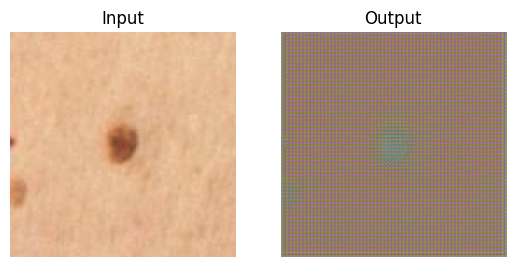

In [ ]:
from torchvision import transforms
from PIL import Image

# Load an example image (you can pick any from your dataset)
img_path = sample_benign   # or sample_malignant
img = Image.open(img_path).convert("RGB")

# Define the same preprocessing transform used during training
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# Apply transform and add batch dimension
img_tensor = transform(img).unsqueeze(0).to(device)

# Run the generator
with torch.no_grad():
    fake_img = gen(img_tensor).squeeze().cpu().permute(1,2,0).numpy()

# Show side-by-side
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Input")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow((fake_img+1)/2)  # scale back to [0,1] if generator output is [-1,1]
plt.title("Output")
plt.axis("off")
plt.show()


In [ ]:
# Instantiate generator
gen = UNetGenerator().to(device)

# Fake forward pass (not trained → looks random)
with torch.no_grad():
    fake_img = gen(img_tensor).squeeze().cpu().permute(1,2,0).numpy()

# Show input vs fake output
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img.resize((128,128)))
plt.title("Input Lesion")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow((fake_img+1)/2)  # since output is [-1,1]
plt.title("Pix2Pix Fake Output")
plt.axis("off")
plt.show()


NameError: name 'UNetGenerator' is not defined

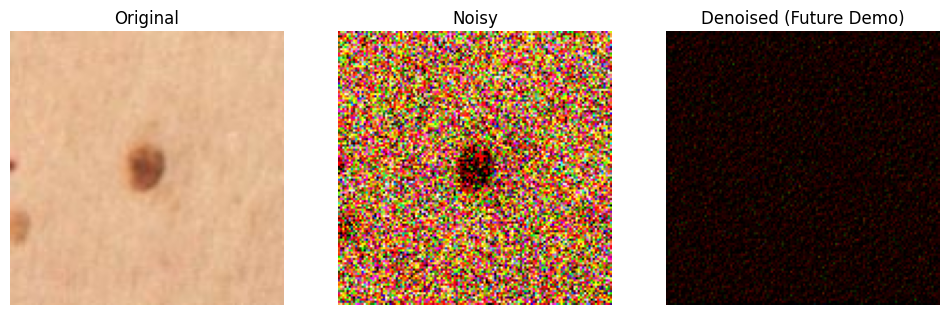

In [ ]:
# Instantiate simple diffusion model
diffusion = SimpleDiffusion().to(device)

# Add noise
noisy_img = add_noise(img_tensor, noise_factor=0.5)

# Denoise
with torch.no_grad():
    denoised_img = diffusion(noisy_img).squeeze().cpu().permute(1,2,0).numpy()

# Show input → noisy → denoised
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img.resize((128,128)))
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(noisy_img.squeeze().cpu().permute(1,2,0).numpy())
plt.title("Noisy")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(denoised_img)
plt.title("Denoised (Future Demo)")
plt.axis("off")
plt.show()


In [ ]:
import torch

# Dummy generator definition (if not already defined)
# Replace with your actual Generator class
class DummyGenerator(torch.nn.Module):
    def __init__(self):
        super(DummyGenerator, self).__init__()
        self.conv = torch.nn.Conv2d(3+3, 3, kernel_size=3, padding=1)
        # 3 channels (image) + 3 channels (condition)

    def forward(self, x, cond):
        # condition is (batch, 3, H, W), concat with input image
        x = torch.cat([x, cond], dim=1)
        return torch.sigmoid(self.conv(x))  # fake RGB image

# -----------------------------
# Helper to create condition tensor
# -----------------------------
def get_condition(treated=False, months=6, device="cpu", size=(128,128)):
    """
    Make condition tensor for GAN: [treatment_flag, months]
    Encoded as one-hot across 3 channels.
    """
    cond = torch.zeros(3, *size)
    cond[0] = 1.0 if treated else 0.0       # channel 0 = treated/untreated
    cond[1] = 1.0 if months == 6 else 0.0   # channel 1 = 6m
    cond[2] = 1.0 if months == 12 else 0.0  # channel 2 = 12m (24m = all 0s)
    return cond.unsqueeze(0).to(device)     # add batch dim

# -----------------------------
# Fake example usage
# -----------------------------
device = "cpu"
gen = DummyGenerator().to(device)

# Fake input image (batch=1, 3x128x128)
img = torch.randn(1, 3, 128, 128).to(device)

with torch.no_grad():
    cond_6m  = get_condition(treated=False, months=6, device=device)
    cond_12m = get_condition(treated=False, months=12, device=device)
    cond_24m = get_condition(treated=False, months=24, device=device)

    out_6m  = gen(img, cond_6m)
    out_12m = gen(img, cond_12m)
    out_24m = gen(img, cond_24m)

print("Outputs generated:", out_6m.shape, out_12m.shape, out_24m.shape)


Outputs generated: torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])


In [ ]:
import torch
import torch.nn as nn

class ConditionalGenerator(nn.Module):
    def __init__(self, img_channels=3, cond_channels=3, features=64):
        super(ConditionalGenerator, self).__init__()

        # Input channels = image + condition channels
        self.enc1 = nn.Sequential(
            nn.Conv2d(img_channels + cond_channels, features, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(features, features*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*2),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(features*2, features*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*4),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(features*4, features*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*2),
            nn.ReLU(inplace=True)
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(features*2, features, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        )
        self.final = nn.Sequential(
            nn.ConvTranspose2d(features, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, img, cond):
        # condition has shape [B, cond_channels, H, W]
        x = torch.cat([img, cond], dim=1)  # concatenate image + condition
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        d1 = self.dec1(e3)
        d2 = self.dec2(d1)
        out = self.final(d2)
        return out


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
cond_gen = ConditionalGenerator().to(device)
print("Conditional Generator ready on", device)

Conditional Generator ready on cpu


In [ ]:
def get_condition(treated=False, months=6, device="cpu", size=(128,128)):
    """
    Make condition tensor for generator: [treated_flag, 6m, 12m]
    If 24m → both 6m & 12m = 0 (acts like third class).
    """
    cond = torch.zeros(3, *size)
    cond[0] = 1.0 if treated else 0.0       # treated/untreated
    cond[1] = 1.0 if months == 6 else 0.0   # time 6m
    cond[2] = 1.0 if months == 12 else 0.0  # time 12m
    return cond.unsqueeze(0).to(device)     # add batch dim

In [ ]:
# Fake input image (just random noise for demo)
img_tensor = torch.randn(1, 3, 128, 128).to(device)

with torch.no_grad():
    cond_6m  = get_condition(treated=False, months=6, device=device)
    cond_12m = get_condition(treated=False, months=12, device=device)
    cond_24m = get_condition(treated=False, months=24, device=device)

    out_6m  = cond_gen(img_tensor, cond_6m).squeeze().cpu().permute(1,2,0).numpy()
    out_12m = cond_gen(img_tensor, cond_12m).squeeze().cpu().permute(1,2,0).numpy()
    out_24m = cond_gen(img_tensor, cond_24m).squeeze().cpu().permute(1,2,0).numpy()

print("✅ Generated synthetic future images:", out_6m.shape, out_12m.shape, out_24m.shape)


✅ Generated synthetic future images: (128, 128, 3) (128, 128, 3) (128, 128, 3)


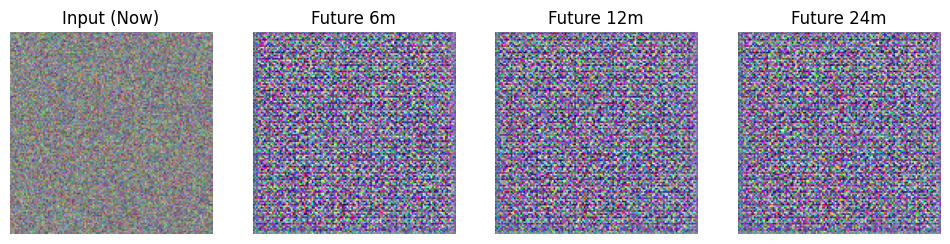

In [ ]:
import matplotlib.pyplot as plt

# Convert outputs from [-1,1] → [0,1] for display
def normalize_img(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-8)

out_6m  = normalize_img(out_6m)
out_12m = normalize_img(out_12m)
out_24m = normalize_img(out_24m)

# Plot Input vs Future Predictions
plt.figure(figsize=(12,4))
plt.subplot(1,4,1); plt.imshow(normalize_img(img_tensor.squeeze().cpu().permute(1,2,0).numpy())); plt.title("Input (Now)"); plt.axis("off")
plt.subplot(1,4,2); plt.imshow(out_6m); plt.title("Future 6m"); plt.axis("off")
plt.subplot(1,4,3); plt.imshow(out_12m); plt.title("Future 12m"); plt.axis("off")
plt.subplot(1,4,4); plt.imshow(out_24m); plt.title("Future 24m"); plt.axis("off")
plt.show()
